In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '/home/brysongray/fibermetric/')
sys.path.insert(0, '/home/brysongray/periodic-kmeans/')
from fibermetric import histology, sta_validate
from fibermetric.sta_validate import parallel_lines_3D_v01
from periodic_kmeans.periodic_kmeans import PeriodicKMeans
# from spherecluster import SphericalKMeans
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib widget
import pandas as pd
import cProfile
import tqdm
import time

# 2D Phantom Tests

In [ ]:
I,_,extent = sta_validate.parallel_lines_2d_v01(thetas=[-np.pi/4], nI=(64,64), period=10, noise=0.001)
S = histology.structure_tensor(I)
angles = histology.angles(S)[0]
fig, ax = plt.subplots(1,2)
ax[0].imshow(I)
ax[1].imshow(angles)

In [ ]:
width = 2
# derivative_sigmas = np.linspace(start=0.25, stop=5.0, num=10)
# tensor_sigmas = np.linspace(start=5.0, stop=17.0, num=10)
periods = [6,10,14]
derivative_sigmas = np.linspace(start=0.15, stop=2.5, num=10)
tensor_sigmas = np.linspace(start=0.0, stop=10.0, num=10)
mean_thetas = np.array([np.pi/6, np.pi/4, np.pi/3])
deltas = np.array([np.pi/12, np.pi/6, np.pi/4, np.pi/3])
grid_thetas = [[(mean - delta/2, mean + delta/2) for delta in deltas] for mean in mean_thetas]
grid_thetas = [item for sublist in grid_thetas for item in sublist] # flatten list of lists

anisotropy = [(240,240), (210,240),(180,240),(150,240),(120,240),(80,240),(60,240)]
AI_ratio = [a[1]/a[0] for a in anisotropy]
print(derivative_sigmas)
print(tensor_sigmas)
print(AI_ratio)
d = 1
t = 3
a = 0
p = 2
# g = 7
err_type = 'piecewise'
error_by_theta = []
for g in range(len(grid_thetas)):
    if g == 6:
        display=True
    else:
        display=False
    error_by_theta.append(sta_validate.phantom_test(derivative_sigmas[d], tensor_sigmas[t], anisotropy[a], period=periods[p], noise=1e-9, width=width, phantom='grid', grid_thetas=[np.pi/2], err_type=err_type, display=display)) # , grid_thetas=(-np.pi/6,np.pi/3)
avg_error = np.mean(error_by_theta)
print(avg_error)
# with cProfile.Profile() as pr:
#     error = sta_validate.phantom_test(derivative_sigmas[d], tensor_sigmas[t], anisotropy[a], period=periods[p], noise=1e-9, width=width, phantom='grid', grid_thetas=grid_thetas[g], err_type=err_type, display=True) # , grid_thetas=(-np.pi/6,np.pi/3)
#     print(f'{err_type} error: {error}')
#     pr.print_stats()

In [ ]:
width = 1
periods = [6,10,14]
derivative_sigmas = np.linspace(start=0.15, stop=2.5, num=10)
tensor_sigmas = np.linspace(start=0.0, stop=10.0, num=10)
# mean_thetas = np.array([np.pi/6, np.pi/4, np.pi/3])
# deltas = np.array([np.pi/12, np.pi/6, np.pi/4, np.pi/3])
# grid_thetas = [[(mean - delta/2, mean + delta/2) for delta in deltas] for mean in mean_thetas]
# grid_thetas = [item for sublist in grid_thetas for item in sublist] # flatten list of lists
# periods = [14]
# derivative_sigmas = [1.0]
# tensor_sigmas = [1.0]
grid_thetas = [[0],[np.pi/12],[np.pi/6],[np.pi/4], [np.pi/3], [5*np.pi/12]]

anisotropy = [(180,240)]
errors = sta_validate.run_tests(derivative_sigmas=derivative_sigmas, tensor_sigmas=tensor_sigmas, nIs=anisotropy, periods=periods, widths=width, noises=1e-9, phantom='grid', grid_thetas=grid_thetas, err_type='piecewise')
# np.save(f'grid_errors_delta0.npy', errors, allow_pickle=True)

In [ ]:
err_type = 'piecewise'
error = sta_validate.phantom_test(0.5, 1.0, (120,240), period=10, noise=1e-9, width=1, phantom='grid', grid_thetas=[-np.pi/2], err_type='piecewise', display=True, crop=None, tile_size=None) # , grid_thetas=(-np.pi/6,np.pi/3)
print(error)

# 3D Line Drawing

In [ ]:
nI = [25,100,100]
dI = [4.0,1.0,1.0]
xI = [np.arange(n)*d for n,d in zip(nI,dI)]
XI = np.stack(np.meshgrid(*xI, indexing='ij'), -1)
labels = np.zeros(nI+[2,])
# theta = np.pi/2
theta = np.pi/3
phi = 0
angles = [theta, phi]
# sigma = (np.sin(theta)*dI[0])**2 + (np.cos(theta)*dI[1])**2
inv_sigma = np.array([[1/dI[0], 0],
                  [0, 1/dI[1]]])
norm = 2*np.pi * np.sqrt(np.sum(1/np.diag(inv_sigma)))
line_thresh = np.exp(-0.5)/norm
v = np.array([np.cos(theta), np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi)])[None]
c0 = np.array([(n-1)*d/2 for n,d in zip(nI,dI)]) # center of the image
projection = (XI - c0) - ((XI - c0)@v.T)*v
xy_dist = np.linalg.norm(projection[...,1:], axis=-1) # distance from each pixel to the line
z_dist = projection[...,0] 
dist = np.stack([z_dist,xy_dist],-1)[...,None,:]
# line = np.exp(-0.5 * dist**2 / sigma) / np.sqrt(2.0*np.pi*sigma)
line = np.exp(-0.5 * dist @ inv_sigma @ dist.transpose(0,1,2,4,3)).squeeze() / norm
line_label = np.where(line[...,None] > line_thresh, [theta,np.pi/2-phi], [0.0,0.0])
labels += line_label
labels = np.where(np.any(labels[...,None] == np.array(angles), axis=3), labels, [0.0,0.0])
extent = [0, nI[0]*dI[0], 0, nI[1]*dI[1]]
# plt.figure()
# plt.imshow(dist[50,:,:], vmin=-10, vmax=10, extent=extent)
fig, axs = plt.subplots(3)
axs[0].imshow(line[nI[0]//2,:,:])
axs[0].set_title('yx')
axs[1].imshow(line[:,nI[1]//2,:], extent=extent)
axs[1].set_title('zx')
axs[2].imshow(line[:,:,nI[2]//2], extent=extent)
axs[2].set_title('zy')

In [3]:
nI = [32,64,64]
dI = [nI[1]/nI[0],1.0,1.0]
theta = 3*np.pi/4
phi = 0
theta2 = 0
phi2 = 0

I, _ = parallel_lines_3D_v01([(theta,phi),(theta2,phi2)], nI, 10, display=False)

increment in xz plane
increment in xy plane
49


Text(0.5, 1.0, 'zy')

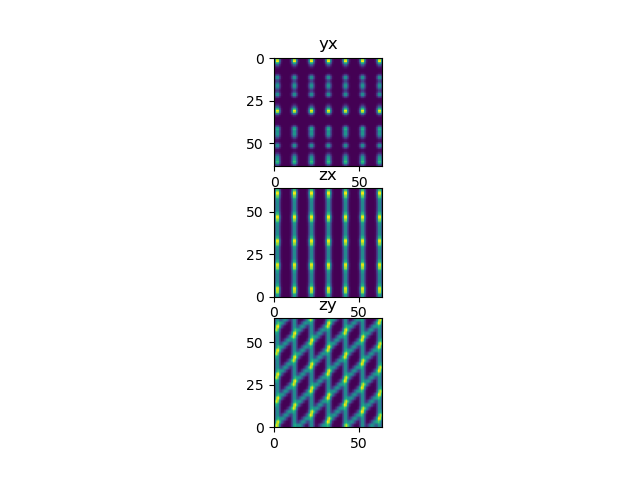

In [13]:
fig, axs = plt.subplots(3)
axs[0].imshow(I[nI[0]//2,:,:])
axs[0].set_title('yx')
axs[1].imshow(I[:,nI[1]//2,:], extent=[0,nI[2]*dI[2],0,nI[0]*dI[0]])
axs[1].set_title('zx')
axs[2].imshow(I[:,:,nI[2]//2], extent=[0,nI[1]*dI[1],0,nI[0]*dI[0]])
axs[2].set_title('zy')

In [4]:
I_corrected,_,extent = sta_validate.anisotropy_correction(I, dI)

In [ ]:
fig, axs = plt.subplots(3)
axs[0].imshow(I_corrected[nI[1]//2,:,:])
axs[0].set_title('yx')
axs[1].imshow(I_corrected[:,nI[1]//2,:])
axs[1].set_title('zx')
axs[2].imshow(I_corrected[:,:,nI[2]//2])
axs[2].set_title('zy')

In [ ]:
I_blurred,_,extent = sta_validate.anisotropy_correction(I, dI, blur=(0.,dI[0]-dI[1],dI[0]-dI[1]))

In [ ]:
fig, axs = plt.subplots(3)
axs[0].imshow(I_blurred[nI[1]//2,:,:])
axs[0].set_title('yx')
axs[1].imshow(I_blurred[:,nI[1]//2,:])
axs[1].set_title('zx')
axs[2].imshow(I_blurred[:,:,nI[2]//2])
axs[2].set_title('zy')

In [ ]:
# visualize with volume plot
Z,Y,X = np.mgrid[0:32:1,0:64:1,0:64:1]

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=I_blurred.flatten(),
    isomin=0.002,
    isomax=0.008,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

### test 3D structure tensor analysis

In [11]:
S = histology.structure_tensor(I_corrected, derivative_sigma=1.0, tensor_sigma=1.0)
angles = histology.angles(S, cartesian=True)
print(angles.shape)

(64, 64, 64, 3)


In [ ]:
print(f'true theta: {theta}')
fig, axs = plt.subplots(3)
axs[0].imshow(angles[0,nI[1]//2,:,:])
axs[0].set_title('yx')
axs[1].imshow(angles[0,:,nI[1]//2,:])
axs[1].set_title('zx')
axs[2].imshow(angles[0,:,:,nI[2]//2])
axs[2].set_title('zy')

In [ ]:
print(f'true phi: {phi}')
fig, axs = plt.subplots(3)
axs[0].imshow(angles[1,nI[1]//2,:,:])
axs[0].set_title('yx')
axs[1].imshow(angles[1,:,nI[1]//2,:])
axs[1].set_title('zx')
axs[2].imshow(angles[1,:,:,nI[2]//2])
axs[2].set_title('zy')

### 3D structure tensor error estimation

In [13]:
crop = 0
tile_size = 16
# crop boundaries to remove artifacts related to averaging tensors near the edges.
if crop is None:
    crop = 16
elif crop > 0:
    angles = angles[:,crop:-crop, crop:-crop, crop:-crop]
# partition angles into tiles
i, j, k = [x//tile_size for x in angles.shape[:-1]]
angles_ = np.array(angles[:i*tile_size, :j*tile_size, :k*tile_size]) # crop so angles divides evenly into tile_size (must create a new array to change stride lengths too.)
# reshape into tiles by manipulating strides. (np.reshape preserves contiguity of elements, which we don't want in this case)
nbits = angles_.strides[-1]
angles_ = np.lib.stride_tricks.as_strided(angles_, shape=(i, j, k, tile_size, tile_size, tile_size, angles.shape[-1]),
                                          strides=(tile_size*angles_.shape[1]*angles_.shape[2]*angles_.shape[3]*nbits,
                                                   tile_size*angles_.shape[2]*angles_.shape[3]*nbits,
                                                   tile_size*angles_.shape[3]*nbits,
                                                   angles_.shape[1]*angles_.shape[2]*angles_.shape[3]*nbits,
                                                   angles_.shape[2]*angles_.shape[3]*nbits,
                                                   angles_.shape[3]*nbits,
                                                   nbits))
angles_ = angles_.reshape(i,j,k,tile_size**3,angles.shape[-1])
print(angles_.shape)

(4, 4, 4, 4096, 3)


In [4]:
grid_thetas = [(0,0),(np.pi/4,0),(np.pi/4,np.pi/2),(np.pi/2,np.pi/2)]
grid_thetas = np.array(grid_thetas)
grid_vectors = np.array([np.sin(grid_thetas[:,0])*np.sin(grid_thetas[:,1]),
                        np.sin(grid_thetas[:,0])*np.cos(grid_thetas[:,1]),
                        np.cos(grid_thetas[:,0])
                        ]).T
print(grid_vectors)


[[0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 7.07106781e-01 7.07106781e-01]
 [7.07106781e-01 4.32978028e-17 7.07106781e-01]
 [1.00000000e+00 6.12323400e-17 6.12323400e-17]]


## Phantom Test

### profiling phantom test

In [33]:
with cProfile.Profile() as pr:
    error = sta_validate.phantom_test(derivative_sigma=0.5, tensor_sigma=1.0, period=10, nI=[64,64,64], grid_thetas=[[3*np.pi/2,0], [np.pi/3,np.pi/6]], display=False, return_all=False)
    print(error)
    pr.print_stats(sort='tottime')

increment in xy plane
increment in xz plane
line count: 81
changed
4.3883758863258775
         6858 function calls (6681 primitive calls) in 5.373 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      144    3.761    0.026    4.540    0.032 sta_validate.py:173(draw_line_3D)
        1    0.438    0.438    0.438    0.438 linalg.py:1331(eigh)
      207    0.371    0.002    0.371    0.002 {method 'reduce' of 'numpy.ufunc' objects}
      144    0.349    0.002    0.695    0.005 linalg.py:2357(norm)
        7    0.254    0.036    0.296    0.042 apsym_kmeans.py:25(_apsym_lloyd_iter)
  571/400    0.089    0.000    1.273    0.003 {built-in method numpy.core._multiarray_umath.implement_array_function}
       27    0.035    0.001    0.035    0.001 {built-in method scipy.ndimage._nd_image.correlate1d}
       10    0.014    0.001    0.014    0.001 {method 'argmin' of 'numpy.ndarray' objects}
        1    0.011    0.011    0.328    0.328 

In [30]:
# Profile draw_line_3D

nI = [64,64,64]
dI = [nI[1]/nI[0], 1.0, 1.0]
xI = [np.arange(n)*d for n,d in zip(nI,dI)]
XI = np.stack(np.meshgrid(*xI, indexing='ij'), axis=-1)
I = np.zeros(nI)
theta = np.pi/2
phi = 0.0
direction = np.array([np.cos(theta), np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi)])[None]
point = (32,32,32)
inv_sigma = np.array([[1.0, 0.],
                      [0., 1.0]])
norm = 2*np.pi * np.sqrt(np.sum(1/np.diag(inv_sigma))) 
with cProfile.Profile() as pr:
    for i in range(100):
        projection = (XI - point) - ((XI - point)@direction.T)*direction
        xy_dist = np.linalg.norm(projection[...,1:], axis=-1)
        z_dist = projection[...,0]
        dist = np.stack([z_dist,xy_dist],-1)[...,None,:]
        line = np.exp(-0.5 * dist @ inv_sigma @ dist.transpose(0,1,2,4,3)).squeeze() / norm
        I += line
        if display == True:
            line_label = np.where(line[...,None] > line_thresh, angles, [0.0,0.0])
            labels += line_label

    pr.print_stats(sort='tottime')


         2809 function calls (2709 primitive calls) in 0.523 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100    0.239    0.002    0.239    0.002 {method 'reduce' of 'numpy.ufunc' objects}
      100    0.229    0.002    0.468    0.005 linalg.py:2357(norm)
  300/200    0.051    0.000    0.521    0.003 {built-in method numpy.core._multiarray_umath.implement_array_function}
      100    0.001    0.000    0.053    0.001 shape_base.py:357(stack)
      100    0.001    0.000    0.469    0.005 <__array_function__ internals>:177(norm)
      100    0.000    0.000    0.051    0.001 <__array_function__ internals>:177(concatenate)
      100    0.000    0.000    0.054    0.001 <__array_function__ internals>:177(stack)
      100    0.000    0.000    0.000    0.000 shape_base.py:348(_stack_dispatcher)
      100    0.000    0.000    0.000    0.000 {method 'transpose' of 'numpy.ndarray' objects}
      100    0.000    0.000    0.000 

In [27]:
def draw_line_3D(I, XI, direction, point, inv_sigma, norm, labels=None, line_thresh=None, display=False, angles=None):
    projection = (XI - point) - ((XI - point)@direction.T)*direction
    xy_dist = np.linalg.norm(projection[...,1:], axis=-1)
    z_dist = projection[...,0]
    dist = np.stack([z_dist,xy_dist],-1)[...,None,:]
    line = np.exp(-0.5 * dist @ inv_sigma @ dist.transpose(0,1,2,4,3)).squeeze() / norm
    I += line
    if display:
        line_label = np.where(line[...,None] > line_thresh, angles, [0.0,0.0])
        labels += line_label

    return I, labels

In [29]:
with cProfile.Profile() as pr:
    for i in range(100):
        I, _ = draw_line_3D(I, XI , direction, point, inv_sigma, norm)

pr.print_stats(sort='tottime')

         2902 function calls (2802 primitive calls) in 3.108 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100    2.570    0.026    3.108    0.031 14362611.py:1(draw_line_3D)
      100    0.239    0.002    0.239    0.002 {method 'reduce' of 'numpy.ufunc' objects}
      100    0.233    0.002    0.473    0.005 linalg.py:2357(norm)
  300/200    0.061    0.000    0.537    0.003 {built-in method numpy.core._multiarray_umath.implement_array_function}
      100    0.001    0.000    0.063    0.001 shape_base.py:357(stack)
      100    0.001    0.000    0.474    0.005 <__array_function__ internals>:177(norm)
      100    0.000    0.000    0.061    0.001 <__array_function__ internals>:177(concatenate)
      100    0.000    0.000    0.064    0.001 <__array_function__ internals>:177(stack)
      100    0.000    0.000    0.000    0.000 shape_base.py:348(_stack_dispatcher)
      100    0.000    0.000    0.000    0.000 {method 'tr

In [26]:
with cProfile.Profile() as pr:
    for i in range(100):
        I, _ = sta_validate.draw_line_3D(I, XI , direction, point, inv_sigma, norm)

pr.print_stats(sort='tottime')


         2902 function calls (2802 primitive calls) in 3.155 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100    2.612    0.026    3.155    0.032 sta_validate.py:173(draw_line_3D)
      100    0.242    0.002    0.242    0.002 {method 'reduce' of 'numpy.ufunc' objects}
      100    0.235    0.002    0.477    0.005 linalg.py:2357(norm)
  300/200    0.062    0.000    0.541    0.003 {built-in method numpy.core._multiarray_umath.implement_array_function}
      100    0.001    0.000    0.063    0.001 shape_base.py:357(stack)
      100    0.001    0.000    0.478    0.005 <__array_function__ internals>:177(norm)
      100    0.000    0.000    0.061    0.001 <__array_function__ internals>:177(concatenate)
      100    0.000    0.000    0.064    0.001 <__array_function__ internals>:177(stack)
      100    0.000    0.000    0.000    0.000 shape_base.py:348(_stack_dispatcher)
      100    0.000    0.000    0.000    0.000 shape

### choose parameters for 3D testing

In [38]:
print(error)

7.025899822802432


increment in yz plane
increment in xy plane
line count: 255
error = 6.527772788627814 degrees


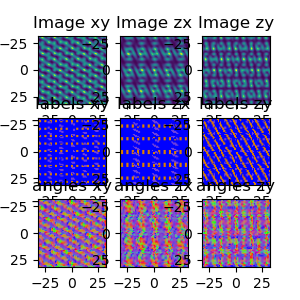

In [4]:
error = sta_validate.phantom_test(derivative_sigma=0.15, tensor_sigma=0.5, period=5, nI=[64,64,64], width=1.0, grid_thetas=[[np.pi/2,np.pi/3], [np.pi/6,np.pi/3]], display=True, return_all=False)

In [ ]:
# we'll choose one average phi that is not aligned with the grid
# choose a few thetas

## Test different mixture modelling methods

In [ ]:
width = 2
periods = 15
derivative_sigmas = np.linspace(start=0.15, stop=2.5, num=10)
tensor_sigmas = np.linspace(start=0.0, stop=8.0, num=10)
mean_thetas = np.array([np.pi/6, np.pi/4, np.pi/3])
deltas = np.array([np.pi/12, np.pi/6, np.pi/4, np.pi/3])
grid_thetas = [[(mean - delta/2, mean + delta/2) for delta in deltas] for mean in mean_thetas]
grid_thetas = [item for sublist in grid_thetas for item in sublist] # flatten list of lists

anisotropy = [(240,240), (210,240),(180,240),(150,240),(120,240),(80,240),(60,240)]
# errors = sta_validate.run_tests(derivative_sigmas=derivative_sigmas, tensor_sigmas=tensor_sigmas, nIs=anisotropy, periods=periods, widths=width, noises=0.0, phantom='grid', grid_thetas=grid_thetas, err_type='piecewise')


In [ ]:
from scipy.stats import vonmises
from sklearn.cluster import KMeans
import time

mu = np.random.rand(2)*np.pi
mu.sort()
kmeans_diff = []
mle_diff = []
periodic_kmeans_diff = []
kmeans_time = []
mle_time = []
periodic_kmeans_time = []
for i in tqdm.tqdm(range(100)):
    vm1 = vonmises.rvs(6.0, loc=mu[0], size=100)
    vm2 = vonmises.rvs(6.0, loc=mu[1], size=100)
    vm = np.concatenate((vm1,vm2))
    vm = np.where(vm < 0, vm + np.pi, vm)
    time1 = time.time()
    kmeans = KMeans(n_clusters=2, random_state=0, algorithm='elkan').fit(vm.reshape(-1,1))
    time2 = time.time()
    mu_kmeans = kmeans.cluster_centers_.reshape(-1)
    mu_kmeans.sort()
    time3 = time.time()
    mu_mle, kappa, pi = histology.vm_maximum_likelihood(vm, verbose=False)
    time4 = time.time()
    mu_mle.sort()
    time5 = time.time()
    periodic_kmeans = PeriodicKMeans(vm.reshape(-1,1), period=np.pi, no_of_clusters=2)
    clust_data, wccs_circ, centers = periodic_kmeans.clustering()
    time6 = time.time()
    mu_periodic_kmeans = np.array(centers).squeeze()
    mu_periodic_kmeans.sort()
    if i==0:
        plt.figure()
        plt.hist(vm, bins='auto', density=True)
        plt.plot([mu[0]]*100, np.linspace(0,0.4,num=100), label='mu1')
        plt.plot([mu[1]]*100, np.linspace(0,0.4,num=100), label='mu2')
        plt.plot([mu_kmeans[0]]*100, np.linspace(0,0.4,num=100), label='kmeans 1')
        plt.plot([mu_kmeans[1]]*100, np.linspace(0,0.4,num=100), label='kmeans 2')
        plt.plot([mu_periodic_kmeans[0]]*100, np.linspace(0,0.4,num=100), label='periodic kmeans 1')
        plt.plot([mu_periodic_kmeans[1]]*100, np.linspace(0,0.4,num=100), label='periodic kmeans 2')
        plt.plot([mu_mle[0]]*100, np.linspace(0,0.4,num=100), label='mle 1')
        plt.plot([mu_mle[1]]*100, np.linspace(0,0.4,num=100), label='mle 2')
        plt.legend()
        plt.show()
    kmeans_diff.append([np.min((np.abs(mu_kmeans[0]-mu[0]), np.pi-np.abs(mu_kmeans[0]-mu[0]))), np.min((np.abs(mu_kmeans[1]-mu[1]), np.pi-np.abs(mu_kmeans[1]-mu[1])))])
    mle_diff.append([np.min((np.abs(mu_mle[0]-mu[0]), np.pi-np.abs(mu_mle[0]-mu[0]))), np.min((np.abs(mu_mle[1]-mu[1]), np.pi-np.abs(mu_mle[1]-mu[1])))])
    periodic_kmeans_diff.append([np.min((np.abs(mu_periodic_kmeans[0]-mu[0]), np.pi-np.abs(mu_periodic_kmeans[0]-mu[0]))), np.min((np.abs(mu_periodic_kmeans[1]-mu[1]), np.pi-np.abs(mu_periodic_kmeans[1]-mu[1])))])
    kmeans_time.append(time2-time1)
    mle_time.append(time4-time3)
    periodic_kmeans_time.append(time6-time5)
kmeans_diff = np.array(kmeans_diff)
mle_diff = np.array(mle_diff)
periodic_kmeans_diff = np.array(periodic_kmeans_diff)

In [ ]:
print(f'kmeans mu1 difference: {np.mean(kmeans_diff[0])}\n kmeans mu2 difference: {np.mean(kmeans_diff[1])}')
print(f'mle mu1 difference: {np.mean(mle_diff[0])}\n mle mu2 difference: {np.mean(mle_diff[1])}')
print(f'periodic_kmeans mu1 difference: {np.mean(periodic_kmeans_diff[0])}\n periodic_kmeans mu2 difference: {np.mean(periodic_kmeans_diff[1])}')
print(f'kmeans time: {np.mean(kmeans_time)}')
print(f'mle time: {np.mean(mle_time)}')
print(f'periodic_kmeans time: {np.mean(periodic_kmeans_time)}')

## Show heatmaps of error for derivative sigmas and tensor sigmas for several anisotropies

In [79]:
column_labels = ['derivative_sigma', 'tensor_sigma', 'nI', 'period', 'width', 'noise', 'phantom',
 'error type', 'grid thetas', 'tile size', 'dimensions', 'error']

periods = [15,10,5]
# load errors
errors_df1 = np.load('/home/brysongray/fibermetric/grid_errors1.npy', allow_pickle=True)
# make erros a pandas dataframe
errors_df1 = pd.DataFrame(errors_df1, columns=column_labels)

errors_df2 = np.load('/home/brysongray/fibermetric/grid_errors2.npy', allow_pickle=True)
# make erros a pandas dataframe
errors_df2 = pd.DataFrame(errors_df2, columns=column_labels)

errors_df3 = np.load('/home/brysongray/fibermetric/grid_errors3.npy', allow_pickle=True)
# make erros a pandas dataframe
errors_df3 = pd.DataFrame(errors_df3, columns=column_labels)
errors_df = [errors_df1, errors_df2, errors_df3]


In [86]:
i=1
derivative_sigmas = errors_df[i]['derivative_sigma'].unique()
tensor_sigmas = errors_df[i]['tensor_sigma'].unique()
anisotropy = errors_df[i]['nI'].unique()
grid_thetas = errors_df[i]['grid thetas'].unique()
print(f'derivative_sigmas: {derivative_sigmas}')
print(f'tensor_sigmas: {tensor_sigmas}')
print(f'grid_thetas: {grid_thetas}')
periods = []
for i in range(len(errors_df)):
    periods.append(errors_df[i]["period"].unique())
    print(f'grid errors {i} period: {periods[i]}')
    print(f'grid errors {i} width: {errors_df[i]["width"].unique()}')
periods = np.array(periods)

derivative_sigmas: [0.15 0.4111111111111111 0.6722222222222223 0.9333333333333335
 1.1944444444444444 1.4555555555555555 1.7166666666666668
 1.9777777777777779 2.238888888888889 2.5]
tensor_sigmas: [0.0 0.8888888888888888 1.7777777777777777 2.6666666666666665
 3.5555555555555554 4.444444444444445 5.333333333333333 6.222222222222221
 7.111111111111111 8.0]
grid_thetas: [(0.39269908169872414, 0.6544984694978735)
 (0.2617993877991494, 0.7853981633974483)
 (0.13089969389957468, 0.916297857297023) (0.0, 1.0471975511965976)
 (0.6544984694978736, 0.916297857297023)
 (0.5235987755982989, 1.0471975511965976)
 (0.39269908169872414, 1.1780972450961724)
 (0.26179938779914946, 1.308996938995747)
 (0.916297857297023, 1.1780972450961724)
 (0.7853981633974483, 1.308996938995747)
 (0.6544984694978735, 1.4398966328953218)
 (0.5235987755982988, 1.5707963267948966)]
grid errors 0 period: [15.0]
grid errors 0 width: [2.0]
grid errors 1 period: [10.0]
grid errors 1 width: [2.0]
grid errors 2 period: [5.0]
g

In [3]:
# column_labels = ['derivative_sigma', 'tensor_sigma', 'nI', 'period', 'width', 'noise', 'phantom',
#   'error type', 'grid thetas', 'tile size', 'dimensions', 'error']
# errors_df = np.load('/home/brysongray/fibermetric/fibermetric/grid_errors_delta0.npy', allow_pickle=True)
# errors_df = pd.DataFrame(errors_df, columns=column_labels)

In [9]:
# derivative_sigmas = errors_df['derivative_sigma'].unique()
# tensor_sigmas = errors_df['tensor_sigma'].unique()
# anisotropy = errors_df['nI'].unique()
# # grid_thetas = errors_df['grid thetas'].unique()
# grid_thetas = np.unique([g[0] for g in errors_df['grid thetas']])
# periods = errors_df['period'].unique()
# print(derivative_sigmas)
# print(tensor_sigmas)

TypeError: list indices must be integers or slices, not str

In [87]:
grid_thetas_np = np.stack(grid_thetas)
delta_thetas = np.abs(grid_thetas_np[:,0] - grid_thetas_np[:,1])
print(delta_thetas)
print(np.unique(delta_thetas.round(8)))

[0.26179939 0.52359878 0.78539816 1.04719755 0.26179939 0.52359878
 0.78539816 1.04719755 0.26179939 0.52359878 0.78539816 1.04719755]
[0.26179939 0.52359878 0.78539816 1.04719755]


In [88]:
# get the number of unique values for each parameter
n_derivative_sigmas = len(derivative_sigmas)
n_tensor_sigmas = len(tensor_sigmas)
n_anisotropy = len(anisotropy)
n_thetas = len(grid_thetas)
n_deltas = len(np.unique(delta_thetas.round(4)))
n_periods = len(periods)

# average the error for each set of grid thetas
errors = np.zeros((n_periods, n_derivative_sigmas, n_tensor_sigmas, n_anisotropy))
errors_by_delta = np.zeros((n_periods, n_derivative_sigmas, n_tensor_sigmas, n_anisotropy, n_deltas))
for i in range(n_periods):
    errors_ = errors_df[i]['error'].values.reshape(-1,n_thetas).astype(float)
    errors_by_delta_ = np.stack([np.mean(errors_[:,i::4], 1) for i in range(4)], axis=1)
    errors_ = np.mean(errors_, axis=1)
    errors_ = errors_.reshape((n_derivative_sigmas, n_tensor_sigmas, n_anisotropy))
    errors_by_delta_ = errors_by_delta_.reshape((n_derivative_sigmas, n_tensor_sigmas, n_anisotropy, n_deltas))
    errors[i] = errors_
    errors_by_delta[i] = errors_by_delta_
errors = errors.transpose(1,2,3,0)
errors_by_delta = errors_by_delta.transpose(1,2,3,4,0)
print(f'errors shape: {errors.shape}')
print(f'errors_by_delta shape: {errors_by_delta.shape}')

errors shape: (10, 10, 7, 3)
errors_by_delta shape: (10, 10, 7, 4, 3)


/tmp/ipykernel_1011638/765926593.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i//cols, i%cols].set_xticklabels(xticklabels, rotation=45)
/tmp/ipykernel_1011638/765926593.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i//cols, i%cols].set_yticklabels(yticklabels)


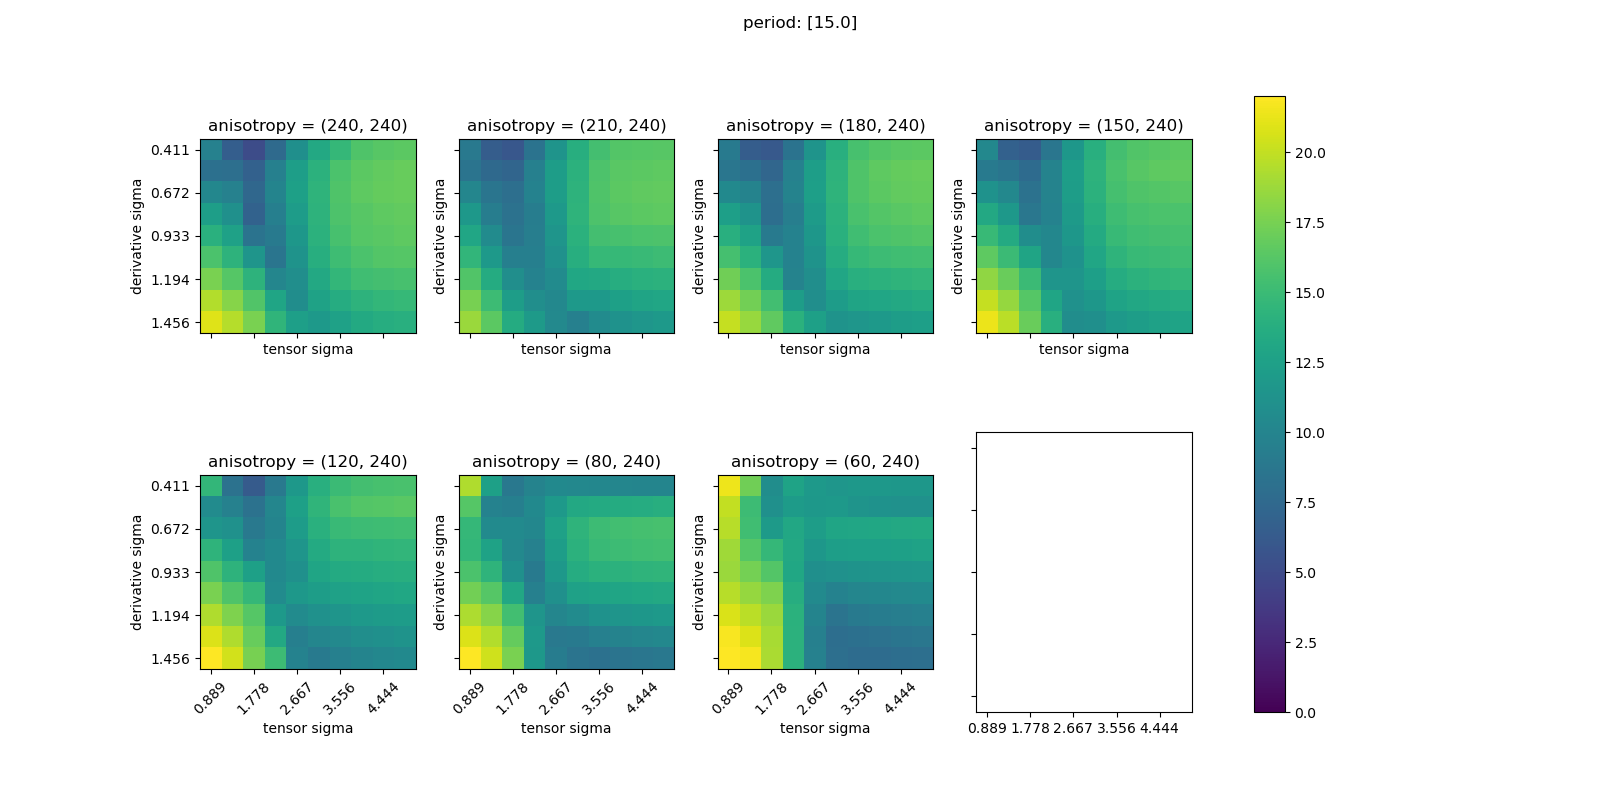

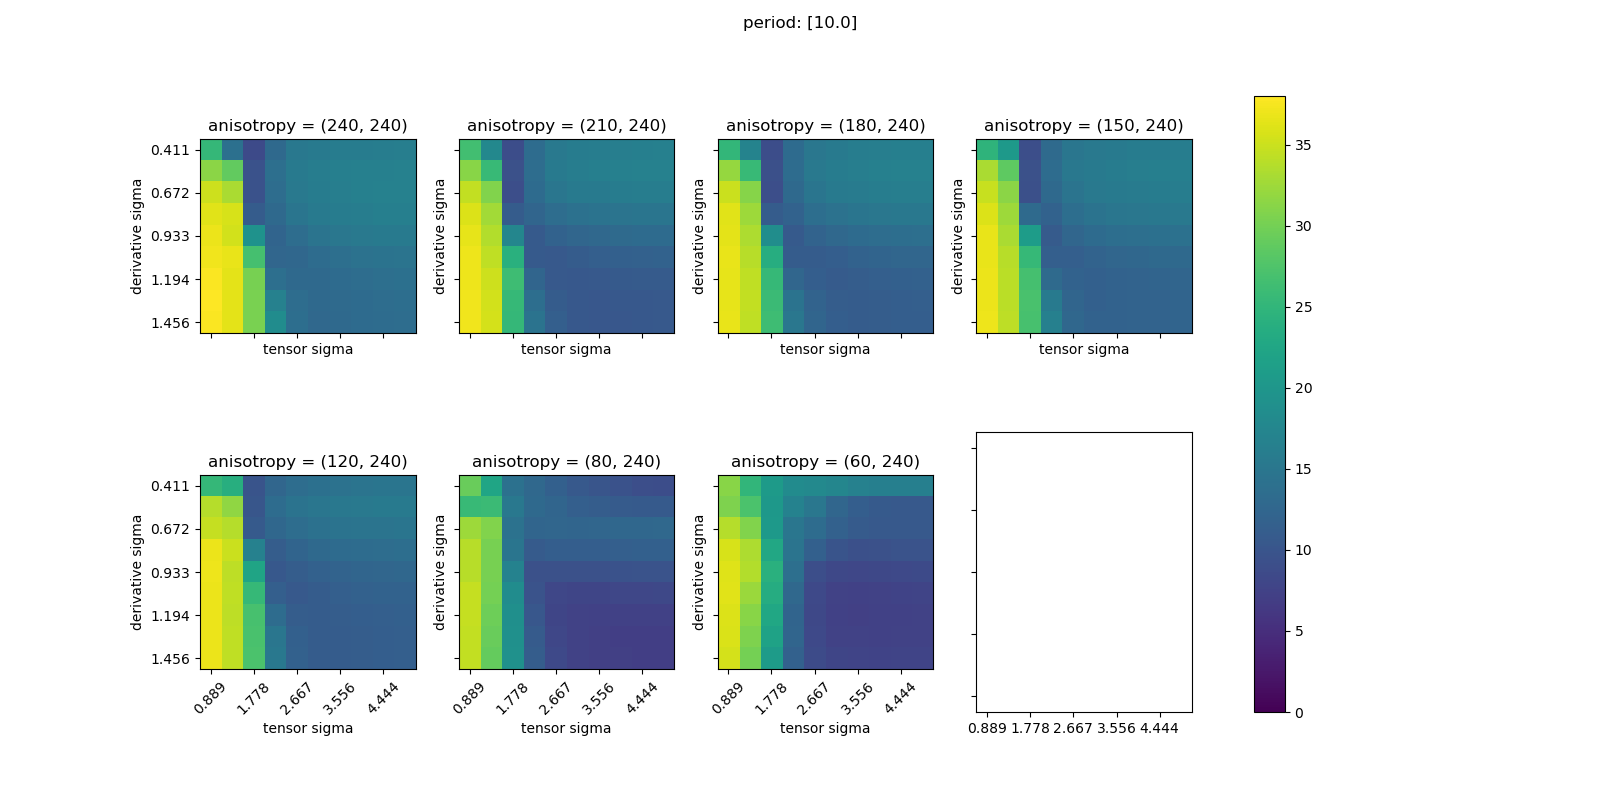

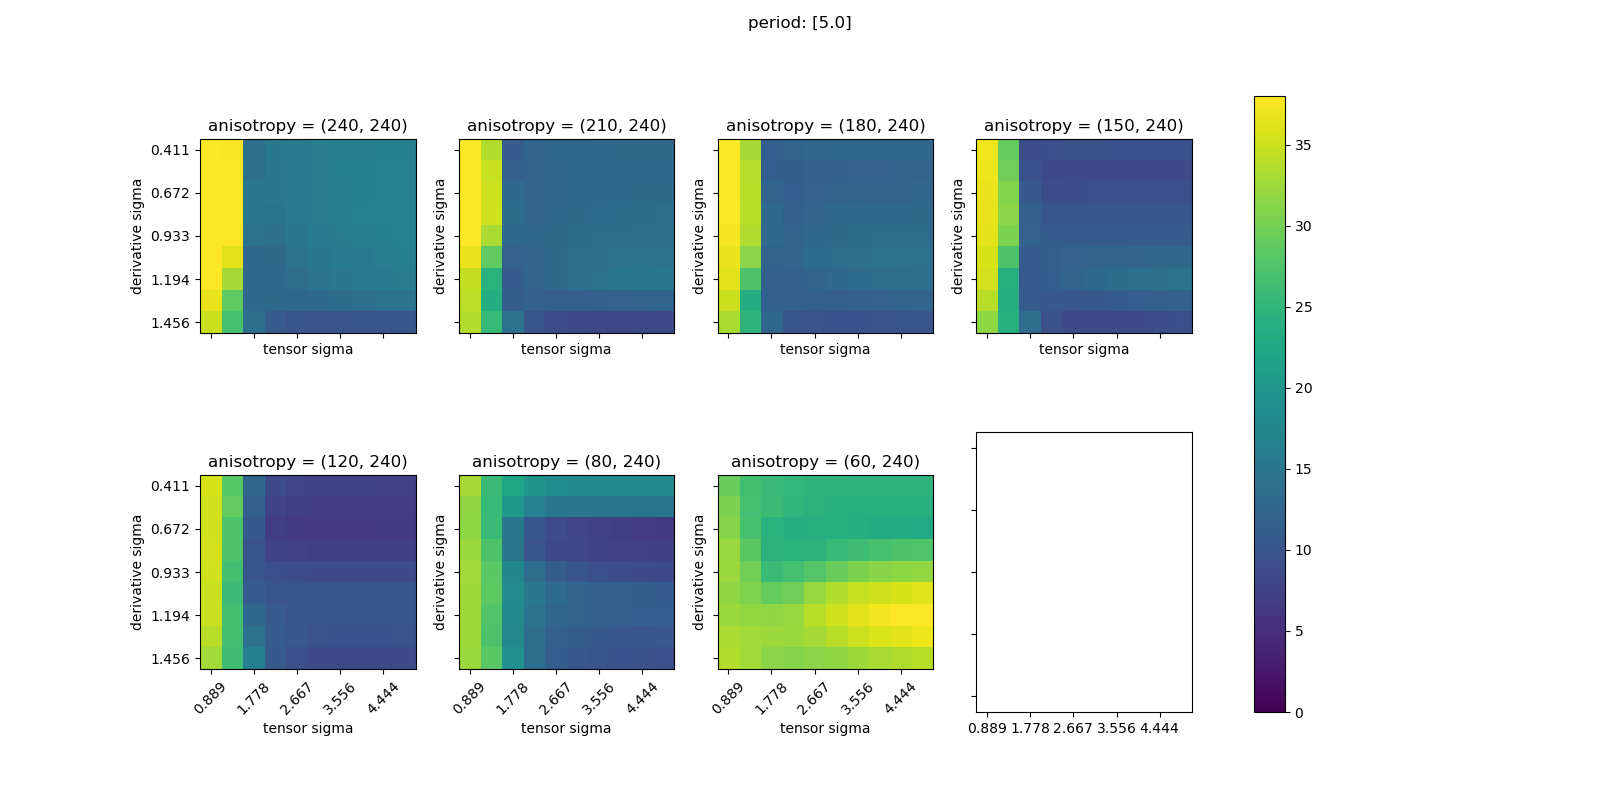

In [89]:
# Display 3 sets of error heatmaps, one set for each period, each set with a heatmap for each anisotropy.
# Each heatmap shows the average errors by derivative sigma and tensor sigma.

# plot the error for each anisotropy
rows = 2
cols = 4
vmax = [22,38,38]
for p in range(n_periods):
    fig, axs = plt.subplots(rows,cols, figsize=(16,8), sharex=True, sharey=True)
    fig.suptitle(f'period: {periods[p]}')
    vm = vmax[p]
    for i in range(n_anisotropy):
        error = errors[...,i,p]
        axs[i//cols,i%cols].imshow(error[1:], vmin=0, vmax=vm)
        axs[i//cols,i%cols].set_title(f'anisotropy = {anisotropy[i]}')
        # set x tick labels
        xticklabels = [f'{t:.3f}' for t in tensor_sigmas]
        yticklabels = [f'{d:.3f}' for d in derivative_sigmas]
        axs[i//cols, i%cols].set_xticklabels(xticklabels, rotation=45)
        axs[i//cols, i%cols].set_yticklabels(yticklabels)
        axs[i//cols,i%cols].set_xlabel('tensor sigma')
        axs[i//cols,i%cols].set_ylabel('derivative sigma')
    # add colorbar to the right
    cbar = fig.colorbar(axs[0,0].images[0], ax=axs, location='right')


## Show error verus anisotropy for the best sigmas 

In [84]:
# find the best sigmas
print(f'errors shape: {errors.shape}')
# the best index will have shape: len(anisotropy) x len(periods) x 2
# the best errors will have shape
best_idx = np.zeros((len(anisotropy), len(periods), 2))
best_errors = np.zeros((len(anisotropy), len(periods)))
for p in range(errors.shape[-1]):
    for i in range(errors.shape[-2]):
        best_idx[i,p] = np.unravel_index(np.argmin(errors[...,i,p]), errors.shape[:-2])
        best_errors[i,p] = np.min(errors[...,i,p])
print(f'best index: {best_idx}\nbest error: {best_errors}')

errors shape: (10, 10, 7, 3)
best index: [[[1. 2.]
  [0. 2.]
  [9. 5.]]

 [[0. 2.]
  [0. 2.]
  [9. 6.]]

 [[0. 2.]
  [0. 2.]
  [9. 6.]]

 [[0. 2.]
  [0. 2.]
  [2. 3.]]

 [[0. 2.]
  [0. 2.]
  [3. 6.]]

 [[9. 6.]
  [8. 9.]
  [3. 9.]]

 [[9. 6.]
  [7. 6.]
  [3. 9.]]]
best error: [[ 5.12266312  6.62631734  9.71373051]
 [ 5.76313333  7.78340242  8.29143781]
 [ 5.87174506  7.92855094  9.52656795]
 [ 6.26401142  8.55641231  8.49989709]
 [ 5.80541779  9.75142939  6.34703292]
 [ 8.24157853  7.04974319  6.38286394]
 [ 7.75067088  7.20649472 23.17571736]]


In [ ]:
plt.close('all')

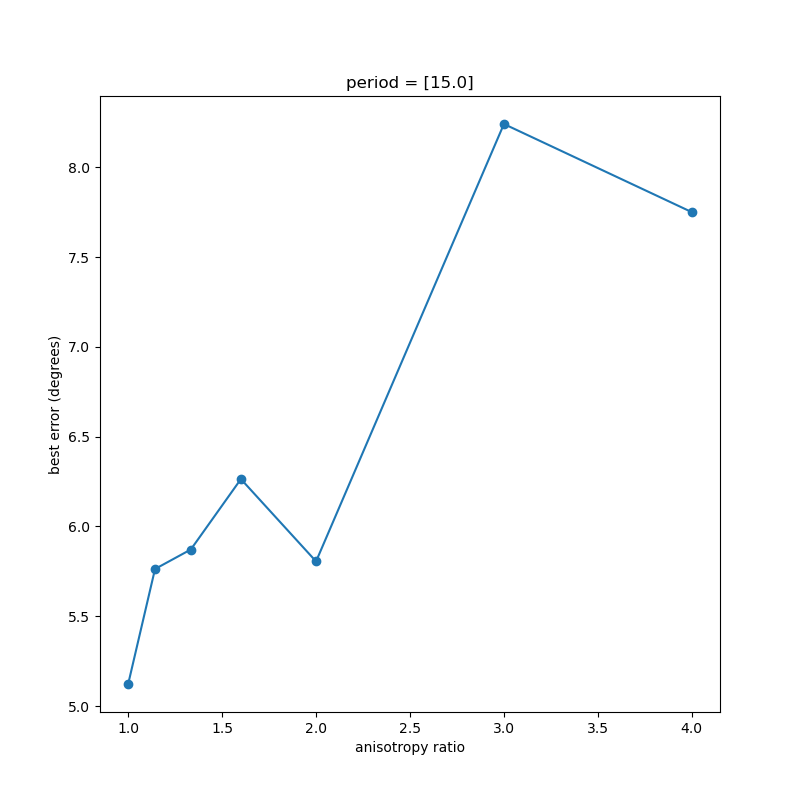

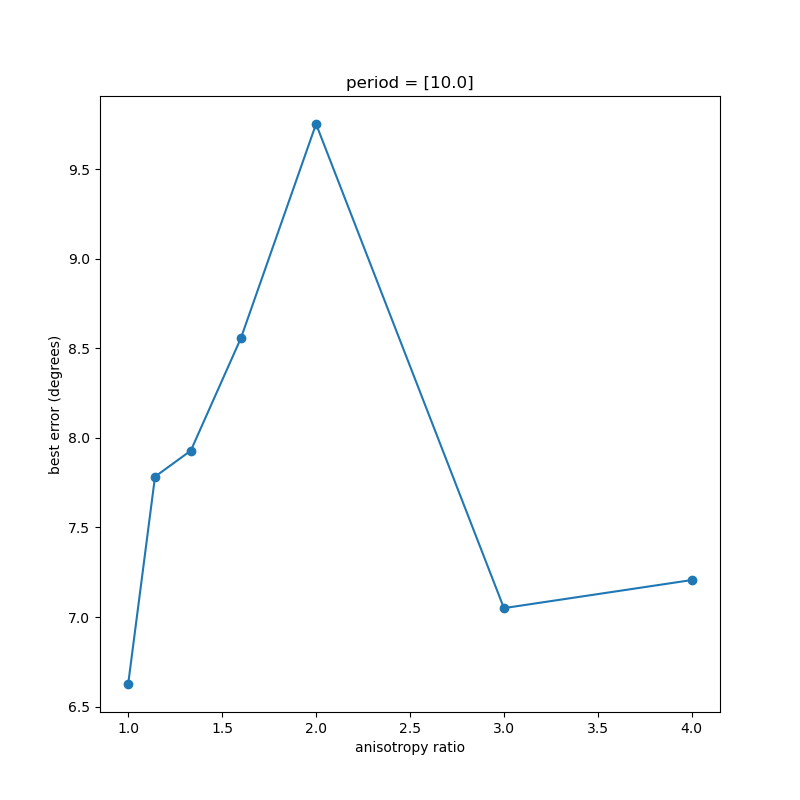

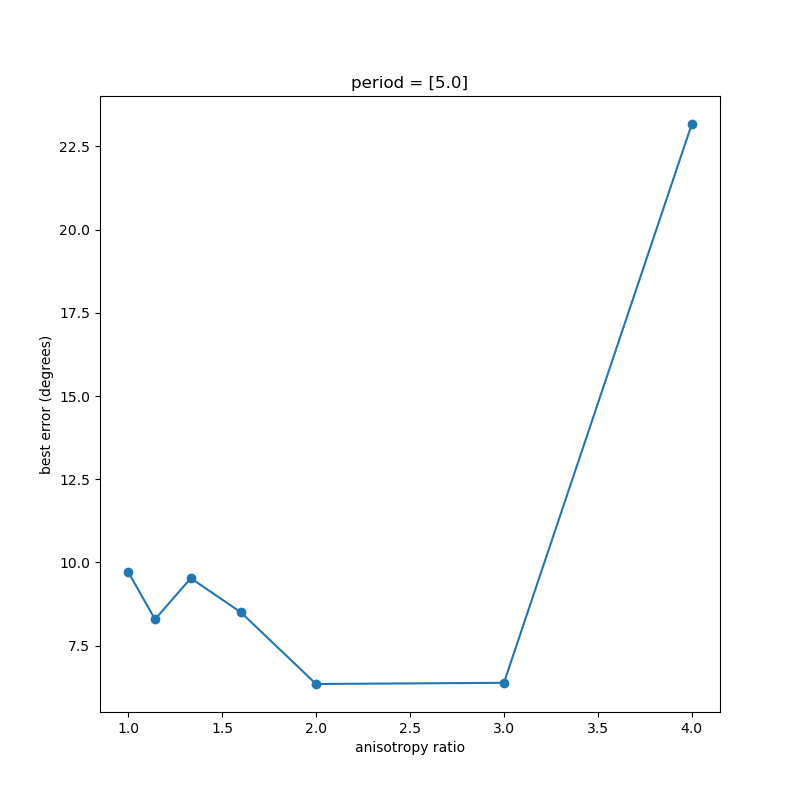

In [85]:
# show best errors for each period and each anisotropy
AI_ratio = [a[1]/a[0] for a in anisotropy]
for p in range(n_periods):
    plt.figure(figsize=(8,8))
    plt.plot(AI_ratio, best_errors[:,p], marker='o')
    plt.title(f'period = {periods[p]}')
    plt.xlabel('anisotropy ratio')
    plt.ylabel('best error (degrees)')


/tmp/ipykernel_1011638/4124076458.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


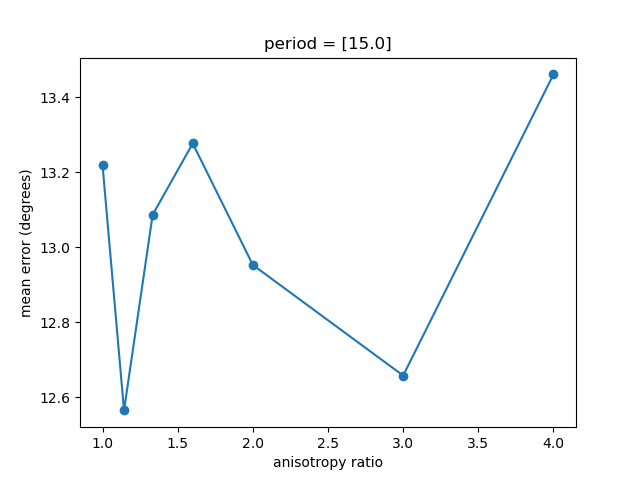

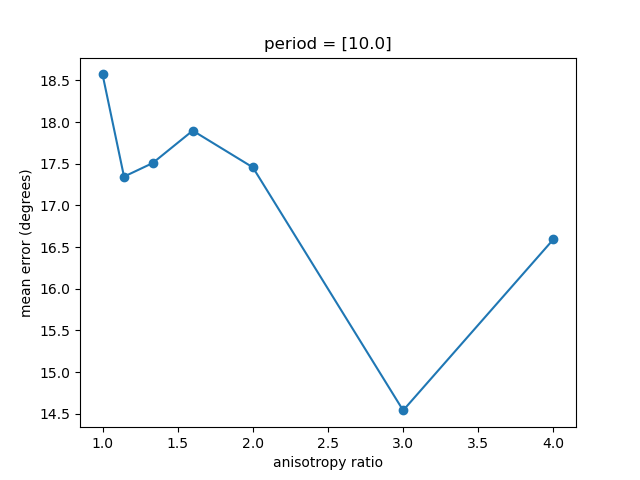

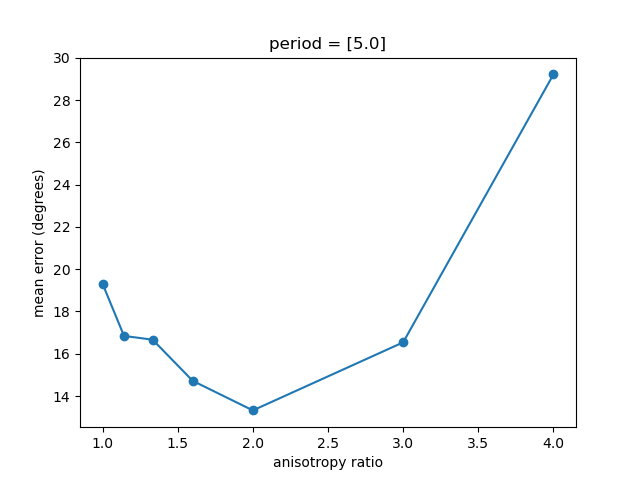

In [61]:
# show the average error versus the anisotropy ratio for each period
for p in range(n_periods):
    plt.figure()
    plt.plot(AI_ratio, np.mean(errors[...,p], axis=(0,1)), marker='o')
    plt.title(f'period = {periods[p]}')
    plt.xlabel('anisotropy ratio')
    plt.ylabel('mean error (degrees)')

In [ ]:
# show the median error versus the anisotropy ratio for each period
for p in range(n_periods):
    plt.figure()
    plt.plot(AI_ratio, np.median(errors[...,p], axis=(0,1)), marker='o')
    plt.title(f'period = {periods[p]}')
    plt.xlabel('anisotropy ratio')
    plt.ylabel('median error (degrees)')

## Show optimal sigmas verus anisotropy for several periods

In [68]:
err_by_period = []
for i in range(3):
    # get the number of unique values for each parameter
    derivative_sigmas = errors_df[i]['derivative_sigma'].unique()
    tensor_sigmas = errors_df[i]['tensor_sigma'].unique()
    anisotropy = errors_df[i]['nI'].unique()
    grid_thetas = errors_df[i]['grid thetas'].unique()
    n_derivative_sigmas = len(derivative_sigmas)
    n_tensor_sigmas = len(tensor_sigmas)
    n_anisotropy = len(anisotropy)
    n_thetas = len(grid_thetas)
    # average the error for each set of grid thetas
    errors = errors_df[i]['error'].values.reshape(-1,n_thetas).astype(float)
    errors = np.mean(errors, axis=1)
    errors = errors.reshape((n_derivative_sigmas, n_tensor_sigmas, n_anisotropy))
    err_by_period.append(errors)

In [67]:
errors.shape

(10, 10, 7)

In [69]:
best_idx = np.zeros((3, len(anisotropy), 2))
best_errors = np.zeros((3, len(anisotropy)))
for p in range(len(periods)):
    for i in range(errors.shape[-1]):
        errors = err_by_period[p]
        best_idx[p,i] = np.unravel_index(np.argmin(errors[...,i]), errors.shape[:-1])
        best_errors[p,i] = np.min(errors[...,i])

In [70]:
sigma1 = derivative_sigmas[best_idx[...,0].astype(int)]
sigma2 = tensor_sigmas[best_idx[...,1].astype(int)]
print(sigma1)
print(sigma2)

[[0.4111111111111111 0.15 0.15 0.15 0.15 2.5 2.5]
 [0.15 0.15 0.15 0.15 0.15 2.238888888888889 1.9777777777777779]
 [2.5 2.5 2.5 0.6722222222222223 0.9333333333333335 0.9333333333333335
  0.9333333333333335]]
[[1.7777777777777777 1.7777777777777777 1.7777777777777777
  1.7777777777777777 1.7777777777777777 5.333333333333333
  5.333333333333333]
 [1.7777777777777777 1.7777777777777777 1.7777777777777777
  1.7777777777777777 1.7777777777777777 8.0 5.333333333333333]
 [4.444444444444445 5.333333333333333 5.333333333333333
  2.6666666666666665 5.333333333333333 8.0 8.0]]


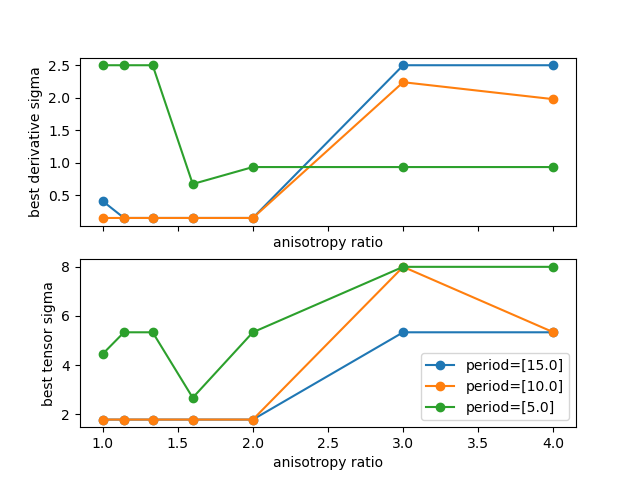

In [75]:
fig, axs = plt.subplots(2, sharex=True)
for i in range(len(periods)):
    axs[0].plot(AI_ratio, sigma1[i], marker='o')
    axs[1].plot(AI_ratio, sigma2[i], marker='o', label=f'period={periods[i]}')
axs[0].set_ylabel('best derivative sigma')
axs[0].set_xlabel('anisotropy ratio')
axs[1].set_ylabel('best tensor sigma')
axs[1].set_xlabel('anisotropy ratio')
axs[1].legend(loc='lower right')
plt.show()

In [ ]:
best_errors = np.zeros((len(anisotropy), len(periods), 4))
for a in range(len(anisotropy)):
    for p in range(len(periods)):
        best_errors[a,p] = errors_by_delta[best_idx[a,p,0].astype(int), best_idx[a,p,1].astype(int), a, p]
print(best_errors.shape)

ValueError: x and y must have same first dimension, but have shapes (4,) and (3,)

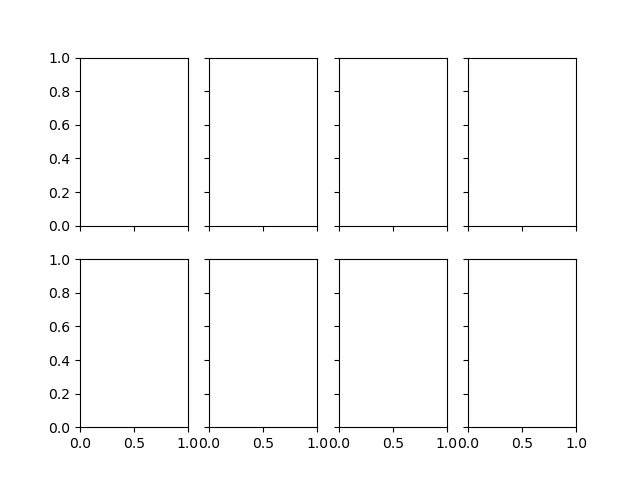

In [76]:
# Show average error versus delta angle at each anisotropy
x_labels = np.unique(np.round(delta_thetas, decimals=3))
avg_errors = np.mean(errors_by_delta, axis=(0,1))
fig, axs = plt.subplots(2,4, sharex=True, sharey=True)
for i in range(len(anisotropy)):
    for j in range(len(periods)):
        axs[i//4,i%4].plot(x_labels, avg_errors[i,j], marker='o', label=f'{periods[j]}')
        # axs[i//4,i%4].plot(x_labels, best_errors[i,j], marker='o', label=f'{periods[j]}')
    axs[i//4, i%4].set_title(f'anisotropy: {anisotropy[i]}')
    axs[i//4, i%4].set_xlabel('delta angle')
    axs[i//4, i%4].set_ylabel('average error')
    axs[i//4, i%4].legend(loc='lower right')



ValueError: x and y must have same first dimension, but have shapes (4,) and (1,)

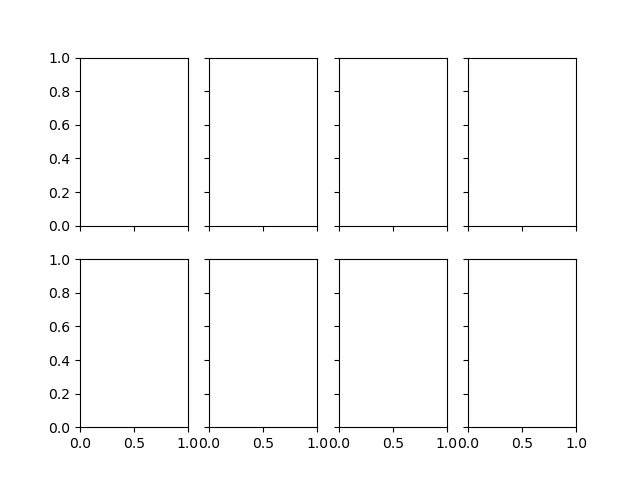

In [77]:
# Show average error versus delta angle at each anisotropy
x_labels = np.unique(np.round(delta_thetas, decimals=3))
# avg_errors = np.mean(errors_by_delta, axis=(0,1))
fig, axs = plt.subplots(2,4, sharex=True, sharey=True)
for i in range(len(anisotropy)):
    for j in range(len(periods)):
        # axs[i//4,i%4].plot(x_labels, avg_errors[i,j], marker='o', label=f'{periods[j]}')
        axs[i//4,i%4].plot(x_labels, best_errors[i,j], marker='o', label=f'{periods[j]}')
    axs[i//4, i%4].set_title(f'anisotropy: {anisotropy[i]}')
    axs[i//4, i%4].set_xlabel('delta angle')
    axs[i//4, i%4].set_ylabel('best error')
    axs[i//4, i%4].legend(loc='lower right')